# Course on Data Science and Geosciences, 2019
# Deep learning lecture

## Simulation and identification of dynamical system using Keras/Neural Networks.




# Rewriting Lorenz-63 dynamics as a Neural Network

In [1]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.datasets import mnist

NbHS     = 3
sigmaL63 = 10.
betaL63  = 8/3
rhoL63   = 28.

## Dynamical model
x_t      = tf.keras.layers.Input((NbHS,))  # Previous members + weights

w0 = np.array([[-1.0*sigmaL63,1.0*sigmaL63,0.0],[1.*rhoL63,-1.0,0.0],[0.,0.,-1.*betaL63]]).transpose()
Dx = tf.keras.layers.Dense(NbHS,weights=[w0],use_bias=False,activation='linear')(x_t)

w0 = np.array([[0.,0.,0.0],[1.,0.0,0.0],[1.,0.,0.]]).transpose()
Dx2_1    = tf.keras.layers.Dense(NbHS,weights=[w0],use_bias=False,activation='linear')(x_t)

w0 = np.array([[0.,0.,0.0],[0.,0.0,-1.0],[0.,1.,0.]]).transpose()
Dx2_2    = tf.keras.layers.Dense(NbHS,weights=[w0],use_bias=False,activation='linear')(x_t)
  
Dx2     = tf.keras.layers.Multiply()([Dx2_1,Dx2_2])
Dx      = tf.keras.layers.Add()([Dx,Dx2])            

dyn_mod = tf.keras.models.Model(x_t,Dx,name='dyn_model')

dyn_mod.summary()

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Model: "dyn_model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 3)]          0                                            
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 3)            9           input_1[0][0]                    
__________________________________________________________________________________________________
dense_2 (Dense)                 (None, 3)            9           input_1[0][0]                    
__________________________________________________________________________________________________
dense (Dense)                   (None, 3)            9           input_1[0][0]                    
_________

## numerical integration using an explicit Euler scheme as a residual network

In [0]:
#from scipy import integrate
import scipy

## numerical integration using neural network function
def NN_lorenz_63(x, t):
     dydt = dyn_mod.predict(x.reshape(1,NbHS)).squeeze()
     return dydt
def lorenz_63(S,t):
    """ Lorenz-63 dynamical model. """
    x_1 = sigmaL63*(S[1]-S[0])
    x_2 = S[0]*(rhoL63-S[2])-S[1]
    x_3 = S[0]*S[1] - betaL63*S[2]
    dS  = np.array([x_1,x_2,x_3]);
    return dS
    
#x_init = np.random.normal(0.,0.1,(3))
x0     = np.array([8.0,0.0,30.0])   
dt     = 0.001
N      = 10000
times  = np.linspace(dt, N*dt, N)
xsimu1  = scipy.integrate.odeint(NN_lorenz_63,  x0, times)
xsimu2  = scipy.integrate.odeint(lorenz_63, x0, times)


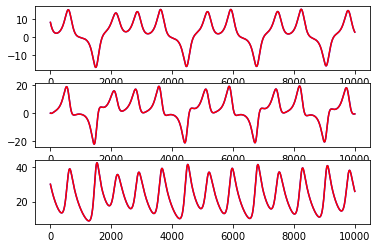

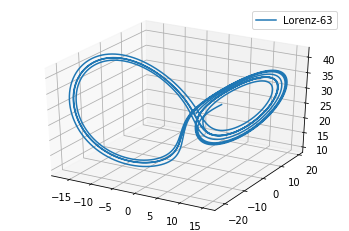

In [6]:
import matplotlib as mpl
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import matplotlib.pyplot as plt

mpl.rcParams['legend.fontsize'] = 10

fig = plt.figure(1)
plt.subplot(311)
plt.plot(xsimu1[:,0],'b-')
plt.plot(xsimu2[:,0],'r-')
plt.subplot(312)
plt.plot(xsimu1[:,1],'b-')
plt.plot(xsimu2[:,1],'r-')
plt.subplot(313)
plt.plot(xsimu1[:,2],'b-')
plt.plot(xsimu2[:,2],'r-')

fig = plt.figure(2)
ax = fig.gca(projection='3d')
ax.plot(xsimu1[:,0], xsimu1[:,1], xsimu1[:,2], label='Lorenz-63')
ax.legend()

plt.show()

# Neural Network version of an Euler integration scheme
## Why don't we get the same simulations using the NN-based integration and the integration implemented in scipy ? 

In [0]:
T = 50

### define ResNet model for a numerical integration over T time steps
x_0      = tf.keras.layers.Input((NbHS,))

x_tt     = tf.keras.layers.Lambda(lambda x: 1.*x)(x_0)

xout     = tf.keras.layers.Reshape((1,NbHS))(x_tt)
for tt in range(0,T):
  dx_tt = dyn_mod(x_tt)
  dx_tt = tf.keras.layers.Lambda(lambda x: dt * x)(dx_tt)
  x_tt  = tf.keras.layers.Add()([x_tt,dx_tt])
  xout  = tf.keras.layers.Concatenate(axis=1)([xout,tf.keras.layers.Reshape((1,NbHS))(x_tt)])

RINN_Euler = tf.keras.models.Model(x_0,xout,name='RINN_Euler')




..... Simulation length : 10000x3


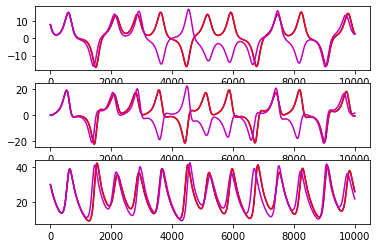

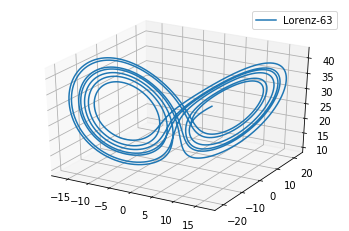

In [8]:
## model simulation
x_init = x0.reshape((1,3)) 

for kk in range(0,int(N/T)):
  x_kk   = RINN_Euler.predict(x_init).squeeze()
  x_init = x_kk[-1,:].reshape((1,NbHS))
  
  if kk == 0:
    xsimu3 = np.copy(x_kk[1:,:])
  else:
    xsimu3 = np.concatenate((xsimu3,x_kk[1:,:]),axis=0)
    
print('..... Simulation length : %dx%d'%(xsimu3.shape[0],xsimu3.shape[1]))

import matplotlib as mpl
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import matplotlib.pyplot as plt

mpl.rcParams['legend.fontsize'] = 10

fig = plt.figure(1)
plt.subplot(311)
plt.plot(xsimu1[:,0],'b-')
plt.plot(xsimu2[:,0],'r-')
plt.plot(xsimu3[:,0],'m-')
plt.subplot(312)
plt.plot(xsimu1[:,1],'b-')
plt.plot(xsimu2[:,1],'r-')
plt.plot(xsimu3[:,1],'m-')
plt.subplot(313)
plt.plot(xsimu1[:,2],'b-')
plt.plot(xsimu2[:,2],'r-')
plt.plot(xsimu3[:,2],'m-')

fig = plt.figure(2)
ax = fig.gca(projection='3d')
ax.plot(xsimu3[:,0], xsimu3[:,1], xsimu3[:,2], label='Lorenz-63')
ax.legend()

plt.show()

# Learning of a NN model for Lorenz-63 dynamics from data

In [11]:
### Data preparation
### generate lorenz-63 data
x0        = np.array([8.0,0.0,30.0])
Ntraining = 10000
dt        = 0.01
times     = np.linspace(dt, Ntraining*dt, Ntraining)
x_training  = scipy.integrate.odeint(NN_lorenz_63,  x0, times)

Ntest   = 1000
times   = np.linspace(dt, Ntest*dt, Ntest)
x_test  = scipy.integrate.odeint(NN_lorenz_63,  x_training[-1,:], times)

# check simulated data
fig = plt.figure(2)
ax = fig.gca(projection='3d')
ax.plot(x_training[:,0], x_training[:,1], x_training[:,2], label='Lorenz-63')
ax.legend()

plt.show()

## derivative data
dx_training = (x_training[1:] - x_training[0:Ntraining-1]) / dt
dx_test     = (x_test[1:]     - x_test[0:Ntest-1]) / dt

# global for normalization
std_xtraining = np.std(x_training[:])

KeyboardInterrupt: ignored

In [12]:
# specify a NN model with unknown parameters
# for the prediction of the derivative

## Dynamical model
x_t      = tf.keras.layers.Input((NbHS,))  # Previous members + weights

Dx = tf.keras.layers.Dense(NbHS,use_bias=False,activation='linear')(x_t)

Dx2_1    = tf.keras.layers.Dense(NbHS,use_bias=False,activation='linear')(x_t)

Dx2_2    = tf.keras.layers.Dense(NbHS,use_bias=False,activation='linear')(x_t)
  
Dx2      = tf.keras.layers.Multiply()([Dx2_1,Dx2_2])
Dx       = tf.keras.layers.Add()([Dx,Dx2])            

dyn_mod2 = tf.keras.models.Model(x_t,Dx,name='dyn_model')

dyn_mod2.summary()



Model: "dyn_model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 3)]          0                                            
__________________________________________________________________________________________________
dense_7 (Dense)                 (None, 3)            9           input_5[0][0]                    
__________________________________________________________________________________________________
dense_8 (Dense)                 (None, 3)            9           input_5[0][0]                    
__________________________________________________________________________________________________
dense_6 (Dense)                 (None, 3)            9           input_5[0][0]                    
__________________________________________________________________________________________

#### 7) Write the code to train the model:

In [13]:
batch_size = 256
epochs     = 500

# model compilation for training
dyn_mod2.compile(loss='mse',
              optimizer=tf.keras.optimizers.RMSprop(lr=1e-3))

# model fit
history = dyn_mod2.fit(x_training[0:-1]/std_xtraining, dx_training/std_xtraining,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_data=(x_test[0:-1]/std_xtraining, dx_test/std_xtraining))

dx_pred = std_xtraining * dyn_mod2.predict(x_test[0:-1]/std_xtraining)
nmse    = np.sum( (dx_pred - dx_test ) **2 ) / np.sum( (dx_test ) **2 )
print('...... relative mse = %.03f'%(nmse))


Train on 9999 samples, validate on 999 samples
Epoch 1/500
9999/9999 [==============================] - 0s 37us/sample - loss: 25.7028 - val_loss: 24.8518
Epoch 2/500
9999/9999 [==============================] - 0s 9us/sample - loss: 24.1290 - val_loss: 23.5388
Epoch 3/500
9999/9999 [==============================] - 0s 8us/sample - loss: 22.8124 - val_loss: 22.3711
Epoch 4/500
9999/9999 [==============================] - 0s 8us/sample - loss: 21.6286 - val_loss: 21.2781
Epoch 5/500
9999/9999 [==============================] - 0s 9us/sample - loss: 20.5283 - val_loss: 20.1742
Epoch 6/500
9999/9999 [==============================] - 0s 9us/sample - loss: 19.4567 - val_loss: 19.1455
Epoch 7/500
9999/9999 [==============================] - 0s 8us/sample - loss: 18.4809 - val_loss: 18.1817
Epoch 8/500
9999/9999 [==============================] - 0s 9us/sample - loss: 17.5557 - val_loss: 17.2711
Epoch 9/500
9999/9999 [==============================] - 0s 8us/sample - loss: 16.6852 - val_los

In [0]:
T = 50
### define ResNet model for a numerical integration over T time steps
x_0      = tf.keras.layers.Input((NbHS,))

x_tt     = tf.keras.layers.Lambda(lambda x: 1.*x)(x_0)

xout     = tf.keras.layers.Reshape((1,NbHS))(x_tt)
for tt in range(0,T):
  dx_tt = dyn_mod(x_tt)
  dx_tt = tf.keras.layers.Lambda(lambda x: dt * x)(dx_tt)
  x_tt  = tf.keras.layers.Add()([x_tt,dx_tt])
  xout  = tf.keras.layers.Concatenate(axis=1)([xout,tf.keras.layers.Reshape((1,NbHS))(x_tt)])

RINN_EulerGT = tf.keras.models.Model(x_0,xout,name='RINN_EulerGT')



### define ResNet model for a numerical integration over T time steps
x_0      = tf.keras.layers.Input((NbHS,))

x_tt     = tf.keras.layers.Lambda(lambda x: 1.*x)(x_0)

xout     = tf.keras.layers.Reshape((1,NbHS))(x_tt)
for tt in range(0,T):
  #dx_tt = dyn_mod2(tf.keras.layers.Lambda(lambda x: 1. * x)(x_tt))
  #dx_tt = tf.keras.layers.Lambda(lambda x: dt * x)(dx_tt)
  dx_tt = dyn_mod2(tf.keras.layers.Lambda(lambda x: np.float(1./std_xtraining) * x)(x_tt))
  dx_tt = tf.keras.layers.Lambda(lambda x: np.float(dt * std_xtraining) * x)(dx_tt)
  x_tt  = tf.keras.layers.Add()([x_tt,dx_tt])
  xout  = tf.keras.layers.Concatenate(axis=1)([xout,tf.keras.layers.Reshape((1,NbHS))(x_tt)])

RINN_Euler2 = tf.keras.models.Model(x_0,xout,name='RINN_Euler2')


In [15]:
x_init = x0.reshape((1,3)) 
x_kk   = RINN_Euler2.predict(x_init).squeeze()
dx4    = std_xtraining * dyn_mod2.predict( x_init / std_xtraining )
dx3    = dyn_mod.predict( x_init )
x_kk1  = x_init +  dt * std_xtraining * dyn_mod2.predict( x_init / std_xtraining )
z_kk   = RINN_EulerGT.predict(x_init).squeeze()

print(x_init)
print(x_kk[-1,:])
print(x_kk1)
print(z_kk[-1,:])
print(dx4)
print(dx3)

[[ 8.  0. 30.]]
[-0.79217577 -1.4447441   8.560074  ]
[[ 7.25296587 -0.25349104 29.29632652]]
[ 9.870712 16.751623 17.1786  ]
[[-74.703415 -25.349106 -70.36735 ]]
[[-80. -16. -80.]]


..... Simulation length : 10000x3


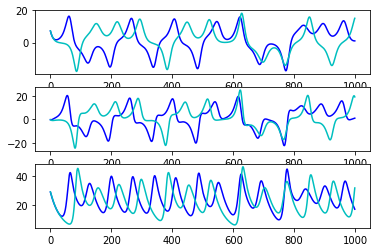

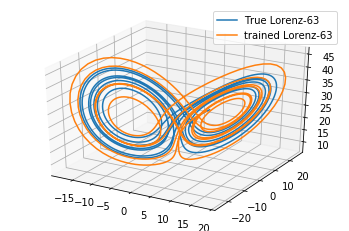

In [16]:
N = 1000

## model simulation with true model
x_init = x0.reshape((1,3)) 

for kk in range(0,int(N/T)):
  x_kk   = RINN_EulerGT.predict(x_init).squeeze()
  x_init = x_kk[-1,:].reshape((1,NbHS))
  
  if kk == 0:
    xsimuGT = np.copy(x_kk[1:,:])
  else:
    xsimuGT = np.concatenate((xsimuGT,x_kk[1:,:]),axis=0)

## model simulation with learnt model
x_init = x0.reshape((1,3)) 

for kk in range(0,int(N/T)):
  x_kk   = RINN_Euler2.predict(x_init).squeeze()
  x_init = x_kk[-1,:].reshape((1,NbHS))
  
  if kk == 0:
    xsimu4 = np.copy(x_kk[1:,:])
  else:
    xsimu4 = np.concatenate((xsimu4,x_kk[1:,:]),axis=0)
    
print('..... Simulation length : %dx%d'%(xsimu3.shape[0],xsimu3.shape[1]))

import matplotlib as mpl
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import matplotlib.pyplot as plt

mpl.rcParams['legend.fontsize'] = 10

fig = plt.figure(1)
plt.subplot(311)
plt.plot(xsimuGT[:,0],'b-')
plt.plot(xsimu4[:,0],'c-')
plt.subplot(312)
plt.plot(xsimuGT[:,1],'b-')
plt.plot(xsimu4[:,1],'c-')
plt.subplot(313)
plt.plot(xsimuGT[:,2],'b-')
plt.plot(xsimu4[:,2],'c-')

fig = plt.figure(2)
ax = fig.gca(projection='3d')
ax.plot(xsimu3[:,0], xsimu3[:,1], xsimu3[:,2], label='True Lorenz-63')
ax.plot(xsimu4[:,0], xsimu4[:,1], xsimu4[:,2], label='trained Lorenz-63')
ax.legend()

plt.show()